In [108]:
import numpy as np
import matplotlib.pyplot as plt
import scipy, sys
import emcee
sys.path.append('/pbs/throng/lsst/users/cpayerne/ClusterLikelihoods/modules/')
import utils

In [126]:
def rhoS(r, M):
    return M*np.exp(-.2*r)

In [127]:
def rhoNS(r, phi, a, b, M):
    rprime = r*np.sqrt(a**2*np.cos(phi)**2 + b**2*np.sin(phi)**2)
    return rhoS(rprime, M)

In [130]:
def rhoNS_polaraveraged(r, a, b, M):
    def __integrand__(x, rad, a, b, M): 
        return rhoNS(rad, x, a, b, M)
    res=[]
    for R in r:
        s=scipy.integrate.quad(__integrand__, 0, 2*np.pi, args=(R, a, b, M))[0]/(2*np.pi)
        res.append(s)
    return np.array(res)

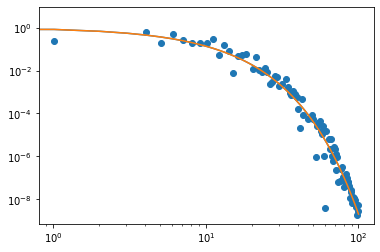

In [132]:
r = np.linspace(0, 100, 100)
M=1
plt.loglog(r, rhoS(r,M))
modelNS=rhoNS_polaraveraged(r,1, 1, M)
plt.loglog(r, modelNS)
err = 1*modelNS
data = modelNS + err*np.random.randn(len(r))
plt.scatter(r, data)

In [134]:
def log_likelihood(theta):
    a, b, M = theta
    y=data
    model = rhoNS_polaraveraged(r, a, b, M)
    sigma2 = err**2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

In [135]:
log_likelihood([1,1, 1])

944.7925781330291

In [137]:
from multiprocessing import Pool
pos = np.array([1,1,1]) + 1e-4 * np.random.randn(10, 3)
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, 3, log_likelihood, pool=pool)
    sampler.run_mcmc(pos, 500, progress=True)

100%|██████████| 500/500 [02:59<00:00,  2.78it/s]


In [138]:
flat_samples = sampler.get_chain(discard=100, thin=2, flat=True)

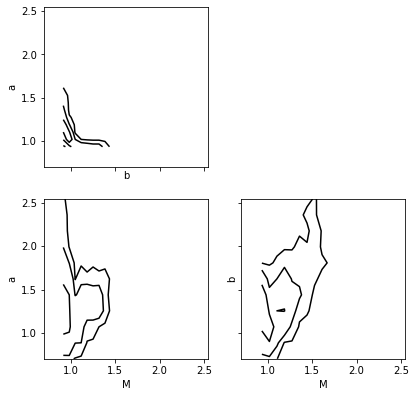

In [163]:
fig, ax=plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)
label=['a', 'b', 'M']
n=11
for i in range(3):
    for j in range(3):
        utils.density_contour(flat_samples[:,i], flat_samples[:,j], n,n, ax=ax[j,i], c='k')
        ax[i,j].set_xlabel(label[i])
        ax[i,j].set_ylabel(label[j])
        if i<=j: fig.delaxes(ax[i,j])